# Gather Data using APIs

In [ ]:
# data 
# we will try to pull data for AMZN share price
# then we will try to predict the stock prices using vanilla RNN 

In [ ]:
!pip install yfinance # uncomment it to download

In [ ]:
%pip install -U git+https://github.com/szagoruyko/pytorchviz.git@master
from torchviz import make_dot, make_dot_from_trace

  Cloning https://github.com/szagoruyko/pytorchviz.git (to revision master) to /tmp/pip-req-build-e8ucdhmz
  Running command git clone -q https://github.com/szagoruyko/pytorchviz.git /tmp/pip-req-build-e8ucdhmz


In [ ]:
# required libraries
import pandas as pd
import numpy as np
import datetime as dt

# for plots
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
# ticker of choice
tick = ['AAPL'] # you can add more or add ticker of choice such as IBM, AAPL, GOOG, GM etc.

# let us start with 2015
begin_period = '2020-06-01'
end_period = '2021-01-01'

In [ ]:
import yfinance as yf
# documentation: https://github.com/ranaroussi/yfinance

In [ ]:
data = yf.download(tick, start=begin_period, end=end_period)
data.head(4)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-06-01,79.437500,80.587502,79.302498,80.462502,79.804390,80791200
2020-06-02,80.187500,80.860001,79.732498,80.834999,80.173843,87642800
2020-06-03,81.165001,81.550003,80.574997,81.279999,80.615211,104491200
2020-06-04,81.097504,81.404999,80.195000,80.580002,79.920944,87560400


In [ ]:
data.tail(12)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-15,124.339996,127.900002,124.129997,127.879997,127.281975,157243700
2020-12-16,127.410004,128.369995,126.559998,127.809998,127.212296,98208600
2020-12-17,128.899994,129.580002,128.039993,128.699997,128.098129,94359800
2020-12-18,128.960007,129.100006,126.120003,126.660004,126.067680,192541500
2020-12-21,125.019997,128.309998,123.449997,128.229996,127.630333,121251600
2020-12-22,131.610001,134.410004,129.649994,131.880005,131.263260,168904800
2020-12-23,132.160004,132.429993,130.779999,130.960007,130.347565,88223700
2020-12-24,131.320007,133.460007,131.100006,131.970001,131.352844,54930100
2020-12-28,133.990005,137.339996,133.509995,136.690002,136.050781,124486200


## including all weekdays in the data

In [ ]:
# quantitative trading strategies often require all weekdays
# df = data.Close
# # let us get all the weekdays in the desired date range
# weekdays = pd.date_range(start= begin_period, end = end_period, freq='B')

# df = df.reindex(weekdays)
# df.head()

In [ ]:
# df = pd.DataFrame(df.fillna(method='bfill'))
# df = df.fillna(0)
# df.head()

In [ ]:
df = pd.DataFrame(data.Close)
# get rownames as columns
df.index.name = 'Date'
df.reset_index(inplace=True)

In [ ]:
print(df.columns)
print(df.dtypes)
print(df.describe)

Index(['Date', 'Close'], dtype='object')
Date     datetime64[ns]
Close           float64
dtype: object
<bound method NDFrame.describe of           Date       Close
0   2020-06-01   80.462502
1   2020-06-02   80.834999
2   2020-06-03   81.279999
3   2020-06-04   80.580002
4   2020-06-05   82.875000
..         ...         ...
145 2020-12-24  131.970001
146 2020-12-28  136.690002
147 2020-12-29  134.869995
148 2020-12-30  133.720001
149 2020-12-31  132.690002

[150 rows x 2 columns]>


In [ ]:
df.tail(12)

,Date,Close
138,2020-12-15,127.879997
139,2020-12-16,127.809998
140,2020-12-17,128.699997
141,2020-12-18,126.660004
142,2020-12-21,128.229996
143,2020-12-22,131.880005
144,2020-12-23,130.960007
145,2020-12-24,131.970001
146,2020-12-28,136.690002
147,2020-12-29,134.869995


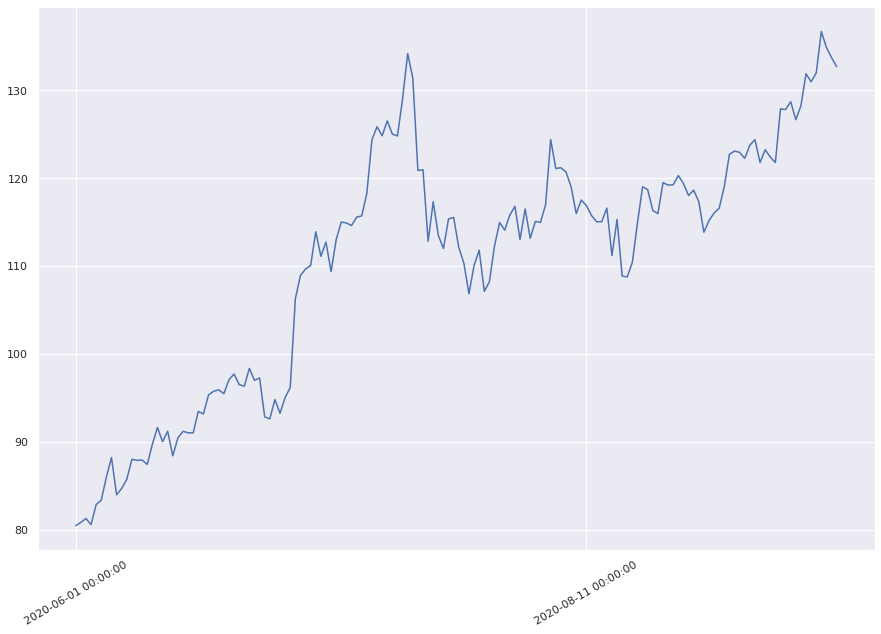

In [ ]:
# let us plot this data
# to do:pls complete the figure with adding lables to axes
sns.set_theme()
plt.figure(figsize= (15, 10))
plt.plot(df.Close)
plt.xticks(range(0, df.shape[0], 100), df.Date.loc[::50], rotation=30)
# plt.plot(roll_mean, color='red')

plt.show()

# Data Prep

In [ ]:
# min max standardization
scale = MinMaxScaler(feature_range=(-1, 1))
# scale.fit_transform(df.Close.values) # gives error that 2D expected and got 1D
df['Close_norm'] = scale.fit_transform(df.Close.values.reshape(-1, 1))

In [ ]:
def train_test_prep(series, window_size, test_prop=0.3): 
  # series should be a numpy series
  series = series.to_numpy()
  data = []
  for i in range(len(series) - window_size):
    data.append(series[i: i+window_size])
  data = np.array(data)

  test_size = int(np.round(test_prop* data.shape[0]))
  train_size = data.shape[0] - test_size

  train_x = data[:train_size, :-1]
  train_y = data[:train_size, -1]

  test_x = data[train_size:, :-1]
  test_y = data[train_size:, -1]

  return [train_x, train_y, test_x, test_y]

In [ ]:
ws = 12

x_train, y_train, x_test, y_test = train_test_prep(df[['Close_norm']], ws)

print('train_x', x_train.shape)#train_x (2106, 11, 1)
print('train_y', y_train.shape)#train_y (2106, 1)

print('test_x', x_test.shape)#test_x (902, 11, 1)
print('test_y', y_test.shape)#test_y (902, 1, 1)

train_x (97, 11, 1)
train_y (97, 1)
test_x (41, 11, 1)
test_y (41, 1)


In [ ]:
# data.Close[:25]

In [ ]:
y_train[:5]

array([[-0.73118154],
       [-0.73553875],
       [-0.73429368],
       [-0.75216758],
       [-0.67080176]])

In [ ]:
print(x_train[:3])

[[[-1.        ]
  [-0.98675034]
  [-0.9709218 ]
  [-0.99582054]
  [-0.91418795]
  [-0.89675884]
  [-0.80312139]
  [-0.72442319]
  [-0.87506125]
  [-0.84927321]
  [-0.81201384]]

 [[-0.98675034]
  [-0.9709218 ]
  [-0.99582054]
  [-0.91418795]
  [-0.89675884]
  [-0.80312139]
  [-0.72442319]
  [-0.87506125]
  [-0.84927321]
  [-0.81201384]
  [-0.73118154]]

 [[-0.9709218 ]
  [-0.99582054]
  [-0.91418795]
  [-0.89675884]
  [-0.80312139]
  [-0.72442319]
  [-0.87506125]
  [-0.84927321]
  [-0.81201384]
  [-0.73118154]
  [-0.73553875]]]


In [ ]:
#  put all arrays to tensors
x_train = torch.from_numpy(x_train).type(torch.Tensor).cuda()
x_test = torch.from_numpy(x_test).type(torch.Tensor).cuda()
y_train = torch.from_numpy(y_train).type(torch.Tensor).cuda()
y_test = torch.from_numpy(y_test).type(torch.Tensor).cuda()


In [ ]:
print('train_x', x_train.shape)#train_x (2106, 11, 1)
print('train_y', y_train.shape)#train_y (2106, 1)

print('test_x', x_test.shape)#test_x (902, 11, 1)
print('test_y', y_test.shape)#test_y (902, 1, 1)

train_x torch.Size([97, 11, 1])
train_y torch.Size([97, 1])
test_x torch.Size([41, 11, 1])
test_y torch.Size([41, 1])


In [ ]:
dataset = TensorDataset(x_train, y_train)

In [ ]:
train_loader = DataLoader(dataset = dataset, batch_size=24, shuffle=True)

In [ ]:
asdf

NameError: ignored

# Vanilla RNN


In [ ]:
# batch_size = 200
input_dim = 1
hidden_dim = 100
num_layers = 1
# out_dim = 1
learning_rate = 0.01
epochs = 1000

In [ ]:
# define RNN
class RNN(nn.Module):
  def __init__(self, input_size=1, hidden_size=100):
    super().__init__()
    self.hidden_size = hidden_size
    
    self.rnn = nn.RNN(input_size = input_size, 
                      hidden_size = hidden_size, 
                      batch_first = True,
                      nonlinearity = 'tanh') # inputs in (batch, seq, features)
    self.fc1 = nn.Linear(hidden_size, 1) # outputing 1 value at the end
    # # h0 
    # self.hidden = torch.zeros(1,1,self.hidden_size)

  def forward(self, x):
    h0 = torch.zeros(1, x.size(0), self.hidden_size).cuda()
    out, self.hidden =  self.rnn(x, h0.detach())
    # print(out.shape)
    # out = out.view(-1, self.hidden_size)
    out = self.fc1(out[:, -1,:])
    # print(out.shape)
    #print('out-length: ', len(out), out)
    return out#[-1]

In [ ]:
# initialize model
model = RNN()
loss_function = nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
model = model.cuda()
model

RNN(
  (rnn): RNN(1, 100, batch_first=True)
  (fc1): Linear(in_features=100, out_features=1, bias=True)
)

In [ ]:
# x = torch.randn(1,8)
# make_dot(model(x_train), params=dict(model.named_parameters()))

In [ ]:
next(model.parameters()).is_cuda

True

In [ ]:
# asdf

In [ ]:
import time

losses = []
start = time.time()
rnn = []

for epoch in range(epochs):
  running_loss = 0
  model.train()
  for x_batch, y_batch in train_loader:
    optimizer.zero_grad()
    # model.hidden = torch.zeros(1,x_train.size(0),model.hidden_size).cuda()
    y_train_pred = model(x_batch)
    loss = torch.sqrt(loss_function(y_train_pred, y_batch))
    loss.backward()
    optimizer.step()
    running_loss+=loss.item()*x_batch.size(0)
    # print('Epoch number: ', epoch, 'Error: ', loss.item())
  epoch_loss = running_loss/len(train_loader.dataset)
  losses.append(epoch_loss)
  print('Epoch number: ', epoch, 'Error: ', losses[-1])
  # loss.backward()
  # optimizer.step()

print('training took: ', time.time() - start)


Epoch number:  0 Error:  0.4193352070665851
Epoch number:  1 Error:  0.41163039453250844
Epoch number:  2 Error:  0.38977222835894715
Epoch number:  3 Error:  0.3732337994673817
Epoch number:  4 Error:  0.36466391799376185
Epoch number:  5 Error:  0.35222748751492844
Epoch number:  6 Error:  0.3407128767792097
Epoch number:  7 Error:  0.33375976933646445
Epoch number:  8 Error:  0.32262603831045406
Epoch number:  9 Error:  0.30975410034976053
Epoch number:  10 Error:  0.2889907422677143
Epoch number:  11 Error:  0.27326348070631323
Epoch number:  12 Error:  0.2589678111457333
Epoch number:  13 Error:  0.24145148679153206
Epoch number:  14 Error:  0.20543736526646564
Epoch number:  15 Error:  0.18263051259456223
Epoch number:  16 Error:  0.16696326357802166
Epoch number:  17 Error:  0.15098316890677227
Epoch number:  18 Error:  0.14256025989031054
Epoch number:  19 Error:  0.13815019302761433
Epoch number:  20 Error:  0.13468479211490178
Epoch number:  21 Error:  0.13338555610671485
Epo

In [ ]:
hist = losses

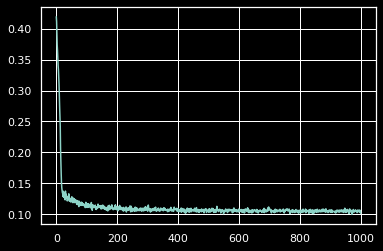

In [ ]:
# plt.figure(figsize = (8, 8))
plt.style.use("dark_background") # https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
plt.plot(losses)
plt.xlabel = 'epochs'
plt.ylabel = 'loss values'
plt.show()

In [ ]:
# predictions = y_train_pred.detach().cpu()
# predictions = scale.inverse_transform(np.array(predictions).reshape(-1, 1))
# predict = pd.DataFrame(predictions)
# predict.head(4)

In [ ]:
predictions = []
with torch.no_grad():
  model.eval()
  for x_batch, y_batch in train_loader:
    predictions.append(model(x_batch))
predictions = torch.cat(predictions).cpu().detach().numpy()
predict = pd.DataFrame(scale.inverse_transform(predictions).flatten())

In [ ]:
predict.head(4)

,0
0,116.099205
1,90.433197
2,91.724129
3,124.044426


In [ ]:
y_train= y_train.detach().cpu()
original = scale.inverse_transform(np.array(y_train).reshape(-1, 1))
original = pd.DataFrame(original)
original.head(4)

,0
0,88.019997
1,87.897499
2,87.932503
3,87.430000


In [ ]:
len(original)

97

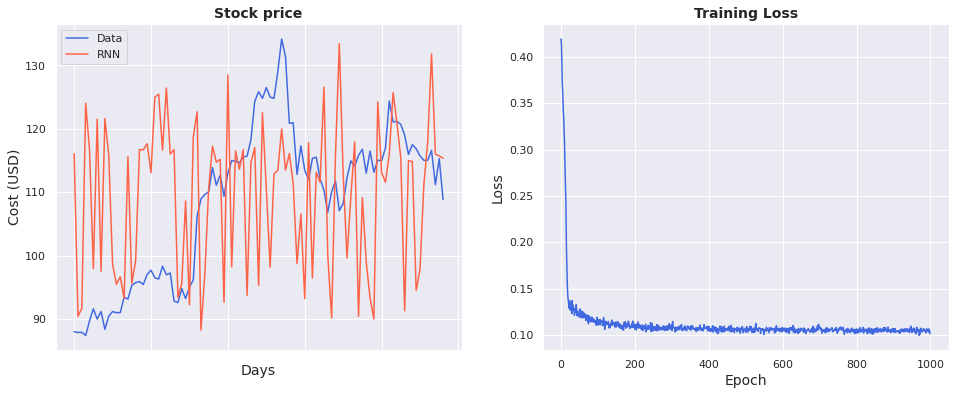

In [ ]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="RNN", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [ ]:
import math, time
from sklearn.metrics import mean_squared_error
model.eval()
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = predict#scale.inverse_transform(y_train_pred.cpu().detach().numpy())
y_train = scale.inverse_transform(y_train)
y_test_pred = scale.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test = scale.inverse_transform(y_test.detach().cpu().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train, y_train_pred))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 3068.88 RMSE
Test Score: 2.20 RMSE


In [ ]:
# Train Score: 2.74 RMSE
# Test Score: 4.01 RMSE

In [ ]:
# future prediction
x_train, y_train, x_test, y_test = train_test_prep(df[['Close_norm']], ws, test_prop=0.0)

print('train_x', x_train.shape)#train_x (2106, 11, 1)
print('train_y', y_train.shape)#train_y (2106, 1)

print('test_x', x_test.shape)#test_x (902, 11, 1)
print('test_y', y_test.shape)#test_y (902, 1, 1)
#  put all arrays to tensors
x_train = torch.from_numpy(x_train).type(torch.Tensor).cuda()
x_test = torch.from_numpy(x_test).type(torch.Tensor).cuda()
y_train = torch.from_numpy(y_train).type(torch.Tensor).cuda()
y_test = torch.from_numpy(y_test).type(torch.Tensor).cuda()

train_x (138, 11, 1)
train_y (138, 1)
test_x (0, 11, 1)
test_y (0, 1)


In [ ]:
# re-train the whole model
# set model to back to training mode
model.train()
import time

losses = np.zeros(epochs)
start = time.time()
rnn = []

for epoch in range(epochs):
  optimizer.zero_grad()
  # model.hidden = torch.zeros(1,1,model.hidden_size).cuda()
  y_train_pred = model(x_train)

  loss = loss_function(y_train_pred, y_train)
  print('Epoch number: ', epoch, 'Error: ', loss.item())
  losses[epoch] = loss.item()
  loss.backward()
  optimizer.step()

print('training took: ', time.time() - start)


Epoch number:  0 Error:  0.01038196962326765
Epoch number:  1 Error:  0.01029512844979763
Epoch number:  2 Error:  0.010219099000096321
Epoch number:  3 Error:  0.010152474977076054
Epoch number:  4 Error:  0.010094019584357738
Epoch number:  5 Error:  0.010042672976851463
Epoch number:  6 Error:  0.00999750941991806
Epoch number:  7 Error:  0.00995772983878851
Epoch number:  8 Error:  0.009922641329467297
Epoch number:  9 Error:  0.009891638532280922
Epoch number:  10 Error:  0.009864200837910175
Epoch number:  11 Error:  0.00983987096697092
Epoch number:  12 Error:  0.009818253107368946
Epoch number:  13 Error:  0.009799010120332241
Epoch number:  14 Error:  0.009781839326024055
Epoch number:  15 Error:  0.009766479022800922
Epoch number:  16 Error:  0.009752708487212658
Epoch number:  17 Error:  0.009740328416228294
Epoch number:  18 Error:  0.009729167446494102
Epoch number:  19 Error:  0.009719081223011017
Epoch number:  20 Error:  0.009709937497973442
Epoch number:  21 Error:  0.

In [ ]:
x_train.shape

In [ ]:
feed = y_train[-11:].view(1,11,1)

In [ ]:
# last = x_train[-1:].cpu().numpy()
last = feed.cpu().numpy()

In [ ]:
last

In [ ]:
# newpred = pred.cpu().detach().numpy()

In [ ]:
# np.append(last, newpred)[-11:]

In [ ]:
# future prediction
# x_, y_, _, _ = train_test_prep(feed, ws, test_prop=0.0)

In [ ]:
last_tensor = torch.from_numpy(last).type(torch.Tensor).view(-1,11, 1).cuda()
last_tensor

In [ ]:
df['Close_norm'].iloc[-11:].values

In [ ]:
# x_train[-1]

In [ ]:
# feed = y_train[-11:].view(1,11,1)# reshape it to suit the input shape of 1,11,1
feed = torch.from_numpy(df['Close_norm'].iloc[-ws:].values).type(torch.Tensor).view(-1,ws, 1).cuda()

last = feed.cpu().numpy()
new_predictions = []
model.eval()
# make predictions
for i in range(12):
  print('before', last)
  last_tensor = torch.from_numpy(last).type(torch.Tensor).view(-1,ws, 1).cuda()
  pred = model(last_tensor)
  new_predictions.append(pred.item())
  newpred = pred.cpu().detach().numpy()
  last = np.append(last, newpred)[-ws:]
  # print('after', last)


before [[[0.68663   ]
  [0.68414015]
  [0.71579725]
  [0.64323515]
  [0.6990794 ]
  [0.82890946]
  [0.7961853 ]
  [0.8321106 ]
  [1.        ]
  [0.93526274]
  [0.8943577 ]
  [0.85772085]]]
before [0.68414015 0.71579725 0.64323515 0.6990794  0.82890946 0.7961853
 0.8321106  1.         0.93526274 0.8943577  0.85772085 0.8394522 ]
before [0.71579725 0.64323515 0.6990794  0.82890946 0.7961853  0.8321106
 1.         0.93526274 0.8943577  0.85772085 0.8394522  0.82057625]
before [0.64323515 0.6990794  0.82890946 0.7961853  0.8321106  1.
 0.93526274 0.8943577  0.85772085 0.8394522  0.82057625 0.7996832 ]
before [0.6990794  0.82890946 0.7961853  0.8321106  1.         0.93526274
 0.8943577  0.85772085 0.8394522  0.82057625 0.7996832  0.78242856]
before [0.82890946 0.7961853  0.8321106  1.         0.93526274 0.8943577
 0.85772085 0.8394522  0.82057625 0.7996832  0.78242856 0.76779217]
before [0.7961853  0.8321106  1.         0.93526274 0.8943577  0.85772085
 0.8394522  0.82057625 0.7996832  0.78

In [ ]:
unscale_new_predictions = scale.inverse_transform(np.array(new_predictions).reshape(-1, 1))
unscale_new_predictions

array([[132.17640185],
       [131.64572792],
       [131.05834629],
       [130.57325334],
       [130.16176932],
       [129.76212419],
       [129.37432465],
       [129.0125489 ],
       [128.68037456],
       [128.3720439 ],
       [128.08342797],
       [127.81428044]])

In [ ]:
df.Close[-12:]

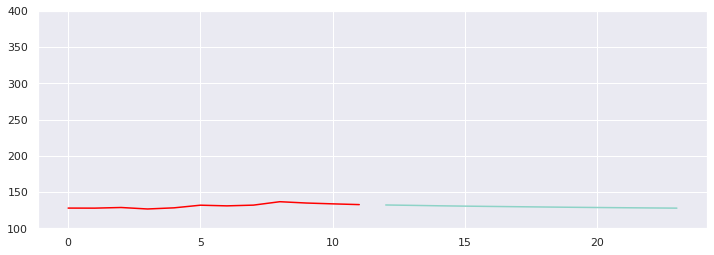

In [ ]:
[x for x in range(12,24)]
fig = plt.figure(figsize=(12,4))
plt.ylim([100, 400])
plt.plot([x for x in range(12)], df.Close[-12:], color = 'red')
plt.plot([x for x in range(12,24)], unscale_new_predictions)
plt.show()

In [ ]:
asdf

## LSTM

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().cuda()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().cuda()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [ ]:
input_dim = 1
hidden_dim = 50
num_layers = 1
output_dim = 1
num_epochs = 400

In [ ]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
model = model.cuda()
cr = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
import time

hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
  y_train_pred = model(x_train)
  loss = cr(y_train_pred, y_train)
  print("Epoch ", t, "MSE: ", loss.item())
  hist[t] = loss.item()

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

In [ ]:
predict = pd.DataFrame(scale.inverse_transform(y_train_pred.cpu().detach().numpy()))
original = pd.DataFrame(scale.inverse_transform(y_train.cpu().detach().numpy()))

In [ ]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure(figsize=(12,12))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='blue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="LSTM", color='red')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [ ]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scale.inverse_transform(y_train_pred.cpu().detach().numpy())
y_train = scale.inverse_transform(y_train.cpu().detach().numpy())
y_test_pred = scale.inverse_transform(y_test_pred.cpu().detach().numpy())
y_test = scale.inverse_transform(y_test.cpu().detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

In [ ]:
# Train Score: 1.98 RMSE
# Test Score: 3.06 RMSE

In [ ]:
# future prediction
x_train, y_train, x_test, y_test = train_test_prep(df[['Close_norm']], ws, test_prop=0.0)

print('train_x', x_train.shape)#train_x (2106, 11, 1)
print('train_y', y_train.shape)#train_y (2106, 1)

print('test_x', x_test.shape)#test_x (902, 11, 1)
print('test_y', y_test.shape)#test_y (902, 1, 1)
#  put all arrays to tensors
x_train = torch.from_numpy(x_train).type(torch.Tensor).cuda()
x_test = torch.from_numpy(x_test).type(torch.Tensor).cuda()
y_train = torch.from_numpy(y_train).type(torch.Tensor).cuda()
y_test = torch.from_numpy(y_test).type(torch.Tensor).cuda()

In [ ]:
# re-train the whole model
# set model to back to training mode
model.train()
import time

losses = np.zeros(num_epochs)
start = time.time()
rnn = []

for epoch in range(num_epochs):
  optimizer.zero_grad()
  # model.hidden = torch.zeros(1,1,model.hidden_size).cuda()
  y_train_pred = model(x_train)

  loss = cr(y_train_pred, y_train)
  print('Epoch number: ', epoch, 'Error: ', loss.item())
  losses[epoch] = loss.item()
  loss.backward()
  optimizer.step()

print('training took: ', time.time() - start)

In [ ]:
model

In [ ]:
# feed = y_train[-11:].view(1,11,1)# reshape it to suit the input shape of 1,11,1
feed = torch.from_numpy(df['Close_norm'].iloc[-ws:].values).type(torch.Tensor).view(-1,ws, 1).cuda()

last = feed.cpu().numpy()
new_predictions = []
model.eval()
# make predictions
for i in range(12):
  print('before', last)
  last_tensor = torch.from_numpy(last).type(torch.Tensor).view(-1,ws, 1).cuda()
  pred = model(last_tensor)
  new_predictions.append(pred.item())
  newpred = pred.cpu().detach().numpy()
  last = np.append(last, newpred)[-ws:]
  # print('after', last)

In [ ]:
df['Close'].iloc[-11:]

In [ ]:
unscale_new_predictions_lstm = scale.inverse_transform(np.array(new_predictions).reshape(-1, 1))
unscale_new_predictions_lstm

In [ ]:
wht = yf.download(tick, start="2021-01-01", end="2021-01-21")['Close']

In [ ]:
[x for x in range(12,24)]
fig = plt.figure(figsize=(12,4))
plt.ylim([100, 200])
plt.plot([x for x in range(12)], df.Close[-12:], color = 'red')
plt.plot([x for x in range(12,24)], unscale_new_predictions_lstm)
plt.plot([x for x in range(12,24)], wht, color='green')
plt.show()

In [ ]:
fut_pred = 12

test_inputs = df['Close_norm'][-11:].tolist()
print(test_inputs)

In [ ]:
model.eval()
feed = torch.from_numpy(df['Close_norm'].iloc[-11:].values).type(torch.Tensor).view(-1,11, 1).cuda()
for i in range(fut_pred):
    seq = feed
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_dim),
                        torch.zeros(1, 1, model.hidden_dim))
        test_inputs.append(model(seq).item())

In [ ]:
test_inputs[fut_pred:]